In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [ ]:
# We can view all of the classes that automap found
Base.classes.keys()

In [ ]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [ ]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)


In [12]:

prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# f: Load the results into a pandas dataframe. Set the index to the `date`
prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<Figure size 360x288 with 0 Axes>

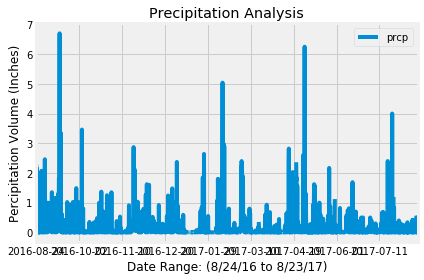

In [14]:
fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Percipitation Volume (Inches)")
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [15]:
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
#Station Analysis
location_station = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations that are available.".format(location_station))


There are 9 stations that are available.


In [17]:
#Active station

weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

popular_station = weather_observations[0][0]    
popular_station

'USC00519281'

In [18]:
# List the stations and the counts in descending order.
print("-----------------------------------------------------------------")
print("The most active station is",popular_station,"and contains",weather_observations[0][1],"weather observations.")
print("-----------------------------------------------------------------")
print("This is a list of the most active stations, displayed in descending order:")
for station, count in weather_observations:
    print("this station id:",station,"has this many weather observations:",count,)

-----------------------------------------------------------------
The most active station is USC00519281 and contains 2772 weather observations.
-----------------------------------------------------------------
This is a list of the most active stations, displayed in descending order:
this station id: USC00519281 has this many weather observations: 2772
this station id: USC00519397 has this many weather observations: 2724
this station id: USC00513117 has this many weather observations: 2709
this station id: USC00519523 has this many weather observations: 2669
this station id: USC00516128 has this many weather observations: 2612
this station id: USC00514830 has this many weather observations: 2202
this station id: USC00511918 has this many weather observations: 1979
this station id: USC00517948 has this many weather observations: 1372
this station id: USC00518838 has this many weather observations: 511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_intel = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

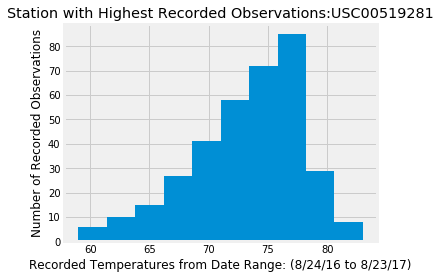

In [21]:
#Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
temp_intel_df = pd.DataFrame(temperature_intel)
plt.hist(temp_intel_df['tobs'])
bin_size = 12
plt.xlabel("Recorded Temperatures from Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Number of Recorded Observations")
plt.title("Station with Highest Recorded Observations:" + popular_station)
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
def calc_temps2(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps2('2017-01-01', '2017-01-20'))


[(60.0, 69.49180327868852, 81.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrival_date = dt.date(2017, 1, 1)
departure_date = dt.date(2017, 1, 20)
one_year_ago = dt.timedelta(days=365)
tavg_year_ago = (calc_temps((arrival_date-one_year_ago), (departure_date-one_year_ago)))
print(tavg_year_ago)

[(61.0, 69.46610169491525, 78.0)]


In [27]:
# Define standard error (max minus min temps)
yerr_val = tavg_year_ago[0][2] - tavg_year_ago[0][0]

# Y value is the average temperature for the trip's date range; X is zero since we only need one bar
y = [tavg_year_ago[0][1]]
x = 0

C:\Users\Fariha\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 360x288 with 0 Axes>

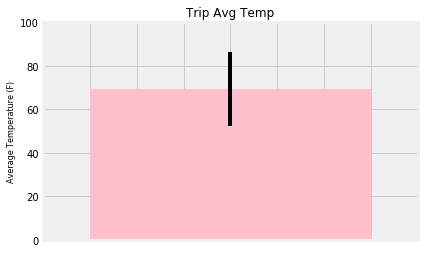

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig3 = plt.figure(figsize=(5,4))
fig, ax = plt.subplots()

# Add  labels, title and axes ticks
ax.set_ylabel("Average Temperature (F)", fontsize=8)
ax.set_title("Trip Avg Temp", fontsize=12)

# Set the limits of the x and y axes, no tick params
ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
